In [ ]:
! pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/ziya07/iot-secure-routing-dataset-for-intrusion-detection'
od.download(dataset_url)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. EDA

In [ ]:
df= pd.read_csv('/content/iot-secure-routing-dataset-for-intrusion-detection/iot_routing_intrusion_dataset.csv')

In [ ]:
df.head(3)

,Packet_ID,Timestamp,Source_Node,Destination_Node,Packet_Size,Protocol,Encryption_Type,Hash_Match,Packet_Delay(ms),Attack_Type,Is_Attack
0,1,2025-06-16 10:00:00,Node_4,Node_1,627,TCP,AES-128,No,12.48,Replay_Attack,1
1,2,2025-06-16 10:00:01,Node_18,Node_3,1273,UDP,AES-128,No,9.31,Replay_Attack,1
2,3,2025-06-16 10:00:02,Node_20,Node_1,1213,TCP,AES-256,Yes,13.24,Normal,0


In [ ]:
df.shape

(10000, 11)

In [ ]:
df.describe()

,Packet_ID,Packet_Size,Packet_Delay(ms),Is_Attack
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,779.234500,10.035308,0.146900
std,2886.89568,417.835417,4.908895,0.354024
min,1.00000,64.000000,0.100000,0.000000
25%,2500.75000,416.000000,6.640000,0.000000
50%,5000.50000,779.500000,9.990000,0.000000
75%,7500.25000,1146.000000,13.360000,0.000000
max,10000.00000,1500.000000,29.630000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Packet_ID         10000 non-null  int64  
 1   Timestamp         10000 non-null  object 
 2   Source_Node       10000 non-null  object 
 3   Destination_Node  10000 non-null  object 
 4   Packet_Size       10000 non-null  int64  
 5   Protocol          10000 non-null  object 
 6   Encryption_Type   10000 non-null  object 
 7   Hash_Match        10000 non-null  object 
 8   Packet_Delay(ms)  10000 non-null  float64
 9   Attack_Type       10000 non-null  object 
 10  Is_Attack         10000 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 859.5+ KB


# 1.1 Count the number of nodes

In [ ]:
def node_number(src, des):

  unique_source_nodes = src.unique()
  unique_destination_nodes = des.unique()

  all_nodes = np.concatenate((unique_source_nodes, unique_destination_nodes))
  unique_nodes = list(np.unique(all_nodes))
  number_of_unique_nodes = len(np.unique(all_nodes))

  return number_of_unique_nodes, unique_nodes

node_number(df['Source_Node'], df['Destination_Node'])

(20,
 ['Node_1',
  'Node_10',
  'Node_11',
  'Node_12',
  'Node_13',
  'Node_14',
  'Node_15',
  'Node_16',
  'Node_17',
  'Node_18',
  'Node_19',
  'Node_2',
  'Node_20',
  'Node_3',
  'Node_4',
  'Node_5',
  'Node_6',
  'Node_7',
  'Node_8',
  'Node_9'])

# 1.2 Class distribution

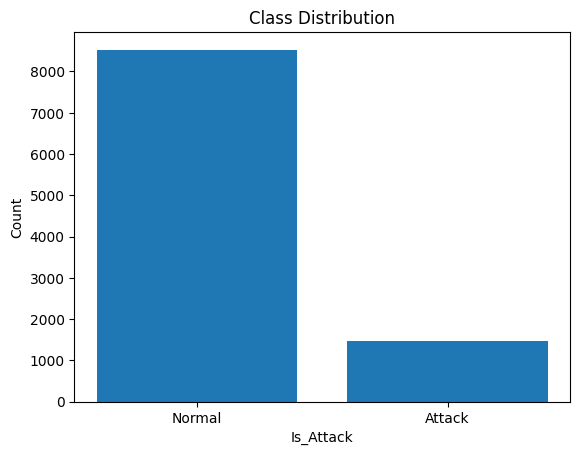

,count
Is_Attack,
0,8531
1,1469


In [ ]:
class_counts = df['Is_Attack'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Is_Attack')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(class_counts.index, ['Normal', 'Attack'])
plt.show()
class_counts

# 1.2.1 Attack class distribution

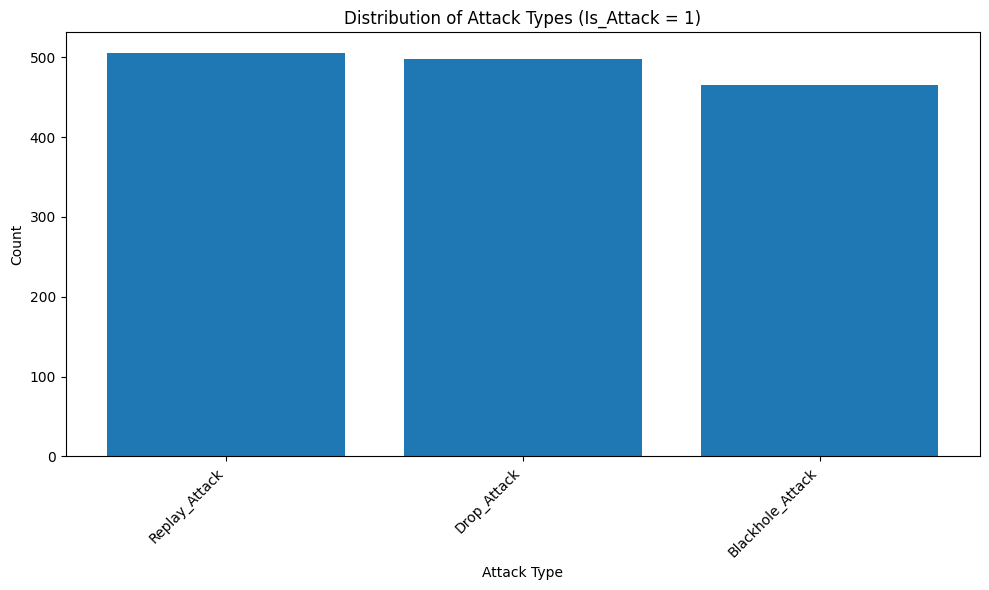

In [ ]:
attacks_type_counts = df[df ['Is_Attack'] == 1]['Attack_Type'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(attacks_type_counts.index, attacks_type_counts.values)
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.title('Distribution of Attack Types (Is_Attack = 1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 1.2.3 Blackhole attack analysis

In [ ]:
def blackhole_attack_node_analysis():
   """ 1.Verify if any node receive lot of paquets and don't send any paquet
     2.Validate the previous assumption by comparing with blackhole malicious node"""

   #for each destination node count its number of appearing as source node
   dest_node = df['Destination_Node'].value_counts()
   src_node= df['Source_Node'].value_counts()
   sub_list = dest_node - src_node
   sort_sub_list = sub_list.sort_values(ascending=False)

   #for each node count how many it appear as a blackhole attack destination
   attack_node = df[(df['Is_Attack'] == 1) & (df['Attack_Type'] == 'Blackhole_Attack')]['Destination_Node'].value_counts()

   return sort_sub_list, attack_node

blackhole_attack_node_analysis()

(Node_8     49
 Node_4     42
 Node_14    33
 Node_15    26
 Node_5     25
 Node_6     25
 Node_7     25
 Node_10    13
 Node_17    10
 Node_16    -3
 Node_9     -6
 Node_1     -9
 Node_2    -13
 Node_13   -16
 Node_18   -19
 Node_12   -22
 Node_11   -27
 Node_20   -31
 Node_19   -45
 Node_3    -57
 Name: count, dtype: int64,
 Destination_Node
 Node_14    34
 Node_16    34
 Node_2     30
 Node_11    30
 Node_5     28
 Node_4     27
 Node_9     27
 Node_19    26
 Node_13    23
 Node_3     22
 Node_10    22
 Node_20    22
 Node_12    21
 Node_18    19
 Node_6     19
 Node_7     18
 Node_8     17
 Node_1     17
 Node_17    16
 Node_15    13
 Name: count, dtype: int64)

# 1.3 Temporal analysis

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

In [ ]:
dt= df.head(1000)
dt

,Packet_ID,Timestamp,Source_Node,Destination_Node,Packet_Size,Protocol,Encryption_Type,Hash_Match,Packet_Delay(ms),Attack_Type,Is_Attack
0,1,2025-06-16 10:00:00,Node_4,Node_1,627,TCP,AES-128,No,12.48,Replay_Attack,1
1,2,2025-06-16 10:00:01,Node_18,Node_3,1273,UDP,AES-128,No,9.31,Replay_Attack,1
2,3,2025-06-16 10:00:02,Node_20,Node_1,1213,TCP,AES-256,Yes,13.24,Normal,0
3,4,2025-06-16 10:00:03,Node_18,Node_14,515,UDP,AES-256,Yes,17.62,Normal,0
4,5,2025-06-16 10:00:04,Node_1,Node_7,1493,UDP,AES-192,Yes,8.83,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...
995,996,2025-06-16 10:16:35,Node_15,Node_19,660,UDP,AES-256,Yes,8.59,Normal,0
996,997,2025-06-16 10:16:36,Node_7,Node_8,1459,UDP,AES-192,Yes,18.99,Normal,0
997,998,2025-06-16 10:16:37,Node_10,Node_15,769,TCP,AES-256,No,13.20,Blackhole_Attack,1
998,999,2025-06-16 10:16:38,Node_5,Node_11,191,UDP,AES-256,Yes,7.14,Normal,0


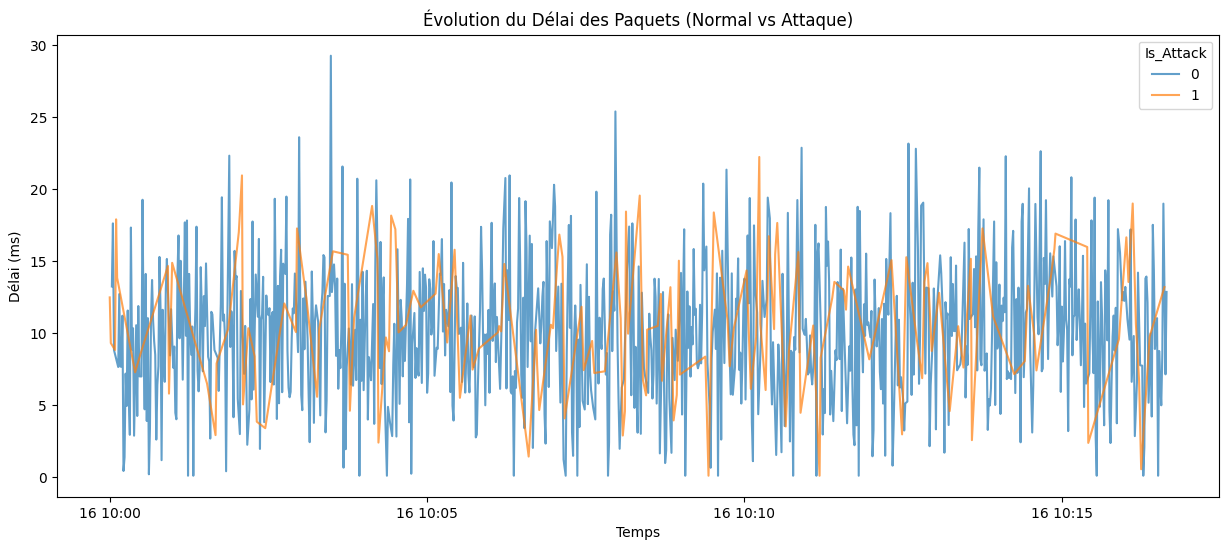

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=dt, x='Timestamp', y='Packet_Delay(ms)', hue='Is_Attack', alpha=0.7)
plt.title("Évolution du Délai des Paquets (Normal vs Attaque)")
plt.xlabel("Temps")
plt.ylabel("Délai (ms)")
plt.show()

In [ ]:
def Distribution_delai_att(df):
  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df, x='Attack_Type', y='Packet_Delay(ms)', palette="viridis")
  plt.title("Distribution du Délai selon le Type d'Attaque")
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()
  return

/tmp/ipython-input-3528667001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Attack_Type', y='Packet_Delay(ms)', palette="viridis")


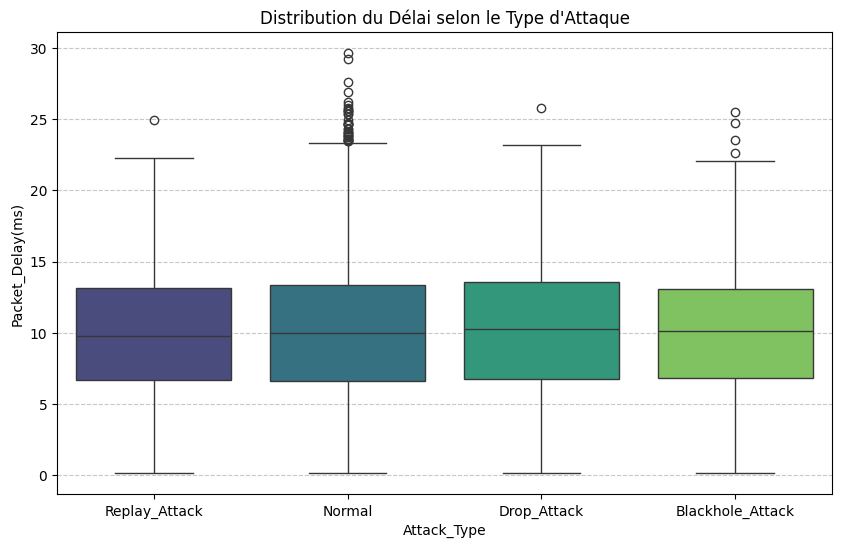

In [ ]:
Distribution_delai_att(df)

/tmp/ipython-input-3528667001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Attack_Type', y='Packet_Delay(ms)', palette="viridis")


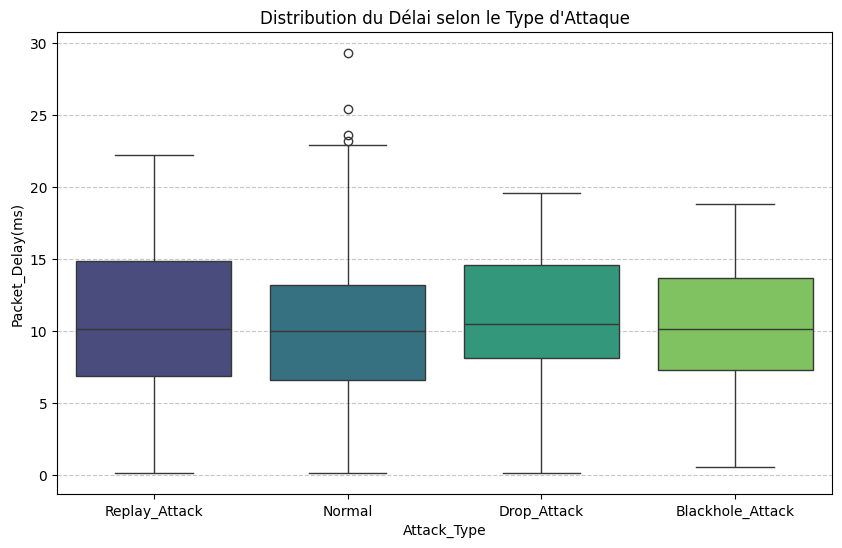

In [ ]:
Distribution_delai_att(dt)

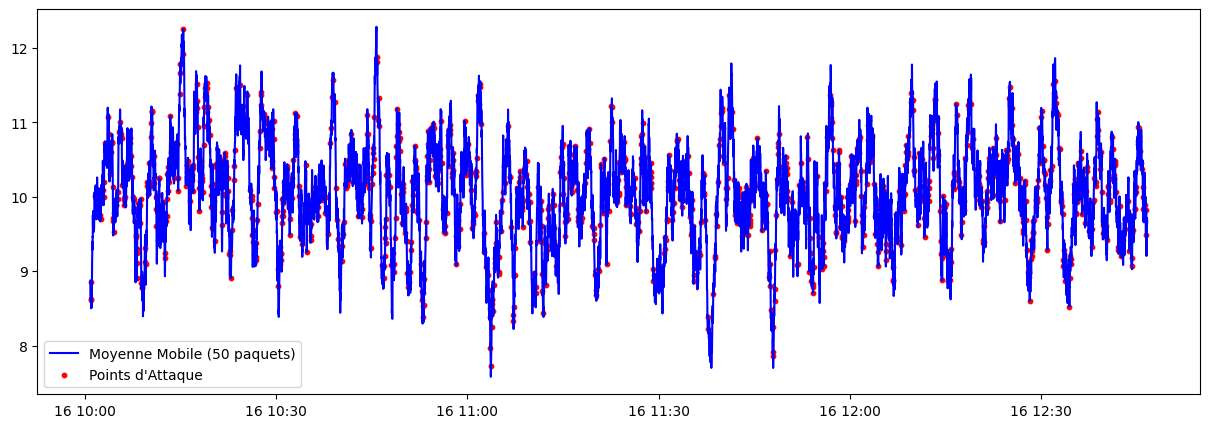

In [ ]:
# Calculate the rollin mean(window = 50)
df['Delay_Rolling'] = df['Packet_Delay(ms)'].rolling(window=50).mean()

plt.figure(figsize=(15, 5))
plt.plot(df['Timestamp'], df['Delay_Rolling'], label="Moyenne Mobile (50 paquets)", color='blue')
plt.scatter(df[df['Is_Attack']==1]['Timestamp'],
            df[df['Is_Attack']==1]['Delay_Rolling'],
            color='red', s=10, label="Points d'Attaque")
plt.legend()
plt.show()